In [1]:
import pyreadr
import pandas as pd

# Specify the path to your .RData file
rdata_file_faulty_training = "/Users/madhuradeval/Documents/MECE 788/Final Project/Data/Output/TEP_Faulty_Training.RData"
rdata_file_faulty_testing = "/Users/madhuradeval/Documents/MECE 788/Final Project/Data/Output/TEP_Faulty_Testing.RData"
rdata_file_fault_free_testing ="/Users/madhuradeval/Documents/MECE 788/Final Project/Data/Output/TEP_FaultFree_Testing.RData"
rdata_file_fault_free_training ="/Users/madhuradeval/Documents/MECE 788/Final Project/Data/Output/TEP_FaultFree_Training.RData"

# Load the .RData file
faulty_training_result = pyreadr.read_r(rdata_file_faulty_training)
faulty_testing_result = pyreadr.read_r(rdata_file_faulty_testing)
fault_free_testing_result = pyreadr.read_r(rdata_file_fault_free_testing)
fault_free_training_result = pyreadr.read_r(rdata_file_fault_free_training)

df_faulty_training = faulty_training_result['faulty_training']
df_faulty_testing = faulty_testing_result['faulty_testing']
df_fault_free_testing = fault_free_testing_result['fault_free_testing']
df_fault_free_training = fault_free_training_result['fault_free_training']

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

df_filtered_fault_free_training = df_fault_free_training.drop(df_fault_free_training.columns[[0,1,2,25,26,27,28,29,30,31,32,33,34,35,36,37,38,29,40,41,42,43,48,52]],axis =1)


X= df_filtered_fault_free_training


# Split and normalize the data
X_train, X_val = train_test_split(X, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the autoencoder architecture
input_dim = X_train_scaled.shape[1]
encoding_dim = 16  # Dimensionality of the encoded representation

encoder = Sequential([
    Dense(24, activation='relu', input_shape=(input_dim,)),
    Dense(encoding_dim, activation='relu')
])

decoder = Sequential([
    Dense(24, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder = Sequential([encoder, decoder])

# Compile and train the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=500,
                batch_size=256,
                validation_data=(X_val_scaled, X_val_scaled))

# Evaluate the autoencoder
reconstruction_error = autoencoder.evaluate(X_val_scaled, X_val_scaled)
print(f'Reconstruction error (MSE): {reconstruction_error}')

Epoch 1/500


2024-04-06 17:20:52.205900: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


782/782 [==============================] - 2s 2ms/step - loss: 0.9298 - val_loss: 0.7573
Epoch 2/500
782/782 [==============================] - 1s 2ms/step - loss: 0.6446 - val_loss: 0.5576
Epoch 3/500
782/782 [==============================] - 1s 2ms/step - loss: 0.4890 - val_loss: 0.4288
Epoch 4/500
782/782 [==============================] - 1s 2ms/step - loss: 0.3903 - val_loss: 0.3560
Epoch 5/500
782/782 [==============================] - 1s 2ms/step - loss: 0.3287 - val_loss: 0.3032
Epoch 6/500
782/782 [==============================] - 2s 2ms/step - loss: 0.2843 - val_loss: 0.2682
Epoch 7/500
782/782 [==============================] - 1s 2ms/step - loss: 0.2557 - val_loss: 0.2441
Epoch 8/500
782/782 [==============================] - 1s 2ms/step - loss: 0.2333 - val_loss: 0.2234
Epoch 9/500
782/782 [==============================] - 1s 1ms/step - loss: 0.2136 - val_loss: 0.2050
Epoch 10/500
782/782 [==============================] - 1s 1ms/step - loss: 0.1972 - val_loss: 0.1906
E

In [3]:
df_filtered_fault_free_testing = df_fault_free_testing.drop(df_fault_free_testing.columns[[0,1,2,25,26,27,28,29,30,31,32,33,34,35,36,37,38,29,40,41,42,43,48,52]],axis =1)
df_filtered_fault_free_testing = scaler.transform(df_filtered_fault_free_testing)
df_filtered_faulty_testing = df_faulty_testing.drop(df_faulty_testing.columns[[0,1,2,25,26,27,28,29,30,31,32,33,34,35,36,37,38,29,40,41,42,43,48,52]],axis =1)
df_filtered_faulty_testing = scaler.transform(df_filtered_faulty_testing)

15000/15000 [==============================] - 3s 184us/step


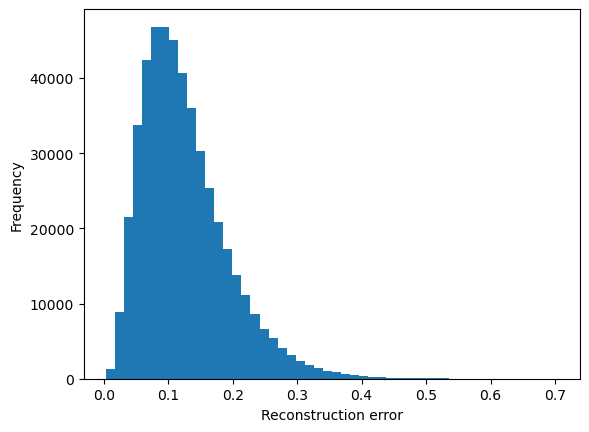

In [4]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
test_data =df_filtered_fault_free_testing
# Use the autoencoder to reconstruct the test data
reconstructed = autoencoder.predict(test_data)

# Calculate the mean squared error of the reconstruction
mse_norm = mean_squared_error(test_data.T, reconstructed.T, multioutput='raw_values')

# Plot the reconstruction error
plt.hist(mse_norm, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.show()

# Set a threshold for anomaly detection
average_mse = statistics.mean(mse_norm)
std_deviation = statistics.stdev(mse_norm)

In [5]:
print('average reconstruction error is:',average_mse)
print('standrad deviation of reconstruction error is:',std_deviation)
threshold = average_mse+std_deviation*3
print('threshold for fault detection is:',threshold )

average reconstruction error is: 0.1258237012251381
standrad deviation of reconstruction error is: 0.06652876552615052
threshold for fault detection is: 0.3254099978035897


300000/300000 [==============================] - 58s 193us/step


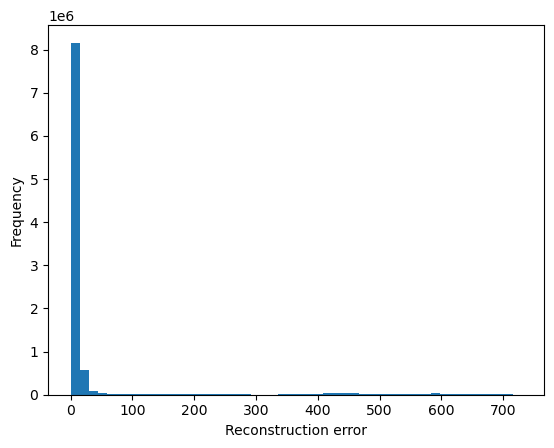

Number of anomalies detected: 4974154


In [6]:
test_data =df_filtered_faulty_testing
# Use the autoencoder to reconstruct the test data
reconstructed = autoencoder.predict(test_data)

# Calculate the mean squared error of the reconstruction
mse_faulty = mean_squared_error(test_data.T, reconstructed.T, multioutput='raw_values')

# Plot the reconstruction error
plt.hist(mse_faulty, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.show()

# Classify a data point as an anomaly if its reconstruction error is greater than the threshold
anomalies = test_data[mse_faulty > threshold]

print(f'Number of anomalies detected: {len(anomalies)}')

In [7]:
from scipy import stats
import numpy as np

# Generate some sample data
group1 = mse_norm
group2 = mse_faulty

# Perform a t-test to compare the means of the two groups
t_stat, p_value = stats.ttest_ind(group1, group2)

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print('The difference between the means is statistically significant.')
else:
    print('The difference between the means is not statistically significant.')

T-statistic: -198.49297950920973
P-value: 0.0
The difference between the means is statistically significant.


In [8]:
df_faulty_testing_one_sim = df_faulty_testing[(df_faulty_testing['faultNumber']==1) & (df_faulty_testing['simulationRun']==10)]
df_filtered_faulty_one_sim_filtered = df_faulty_testing_one_sim.drop(df_faulty_testing_one_sim.columns[[0,1,2,25,26,27,28,29,30,31,32,33,34,35,36,37,38,29,40,41,42,43,48,52]],axis =1)
df_filtered_faulty_one_sim_filtered = df_filtered_faulty_one_sim_filtered.reset_index(drop=True)
df_filtered_faulty_one_sim_filtered_scaled = scaler.transform(df_filtered_faulty_one_sim_filtered) 


In [9]:
#Use the autoencoder to reconstruct the test data
reconstructed = autoencoder.predict(df_filtered_faulty_one_sim_filtered_scaled)

# Calculate the mean squared error of the reconstruction
mse_faulty = mean_squared_error(df_filtered_faulty_one_sim_filtered_scaled.T, reconstructed.T, multioutput='raw_values')

df_filtered_faulty_one_sim_filtered['mse_faulty'] = mse_faulty


30/30 [==============================] - 0s 244us/step


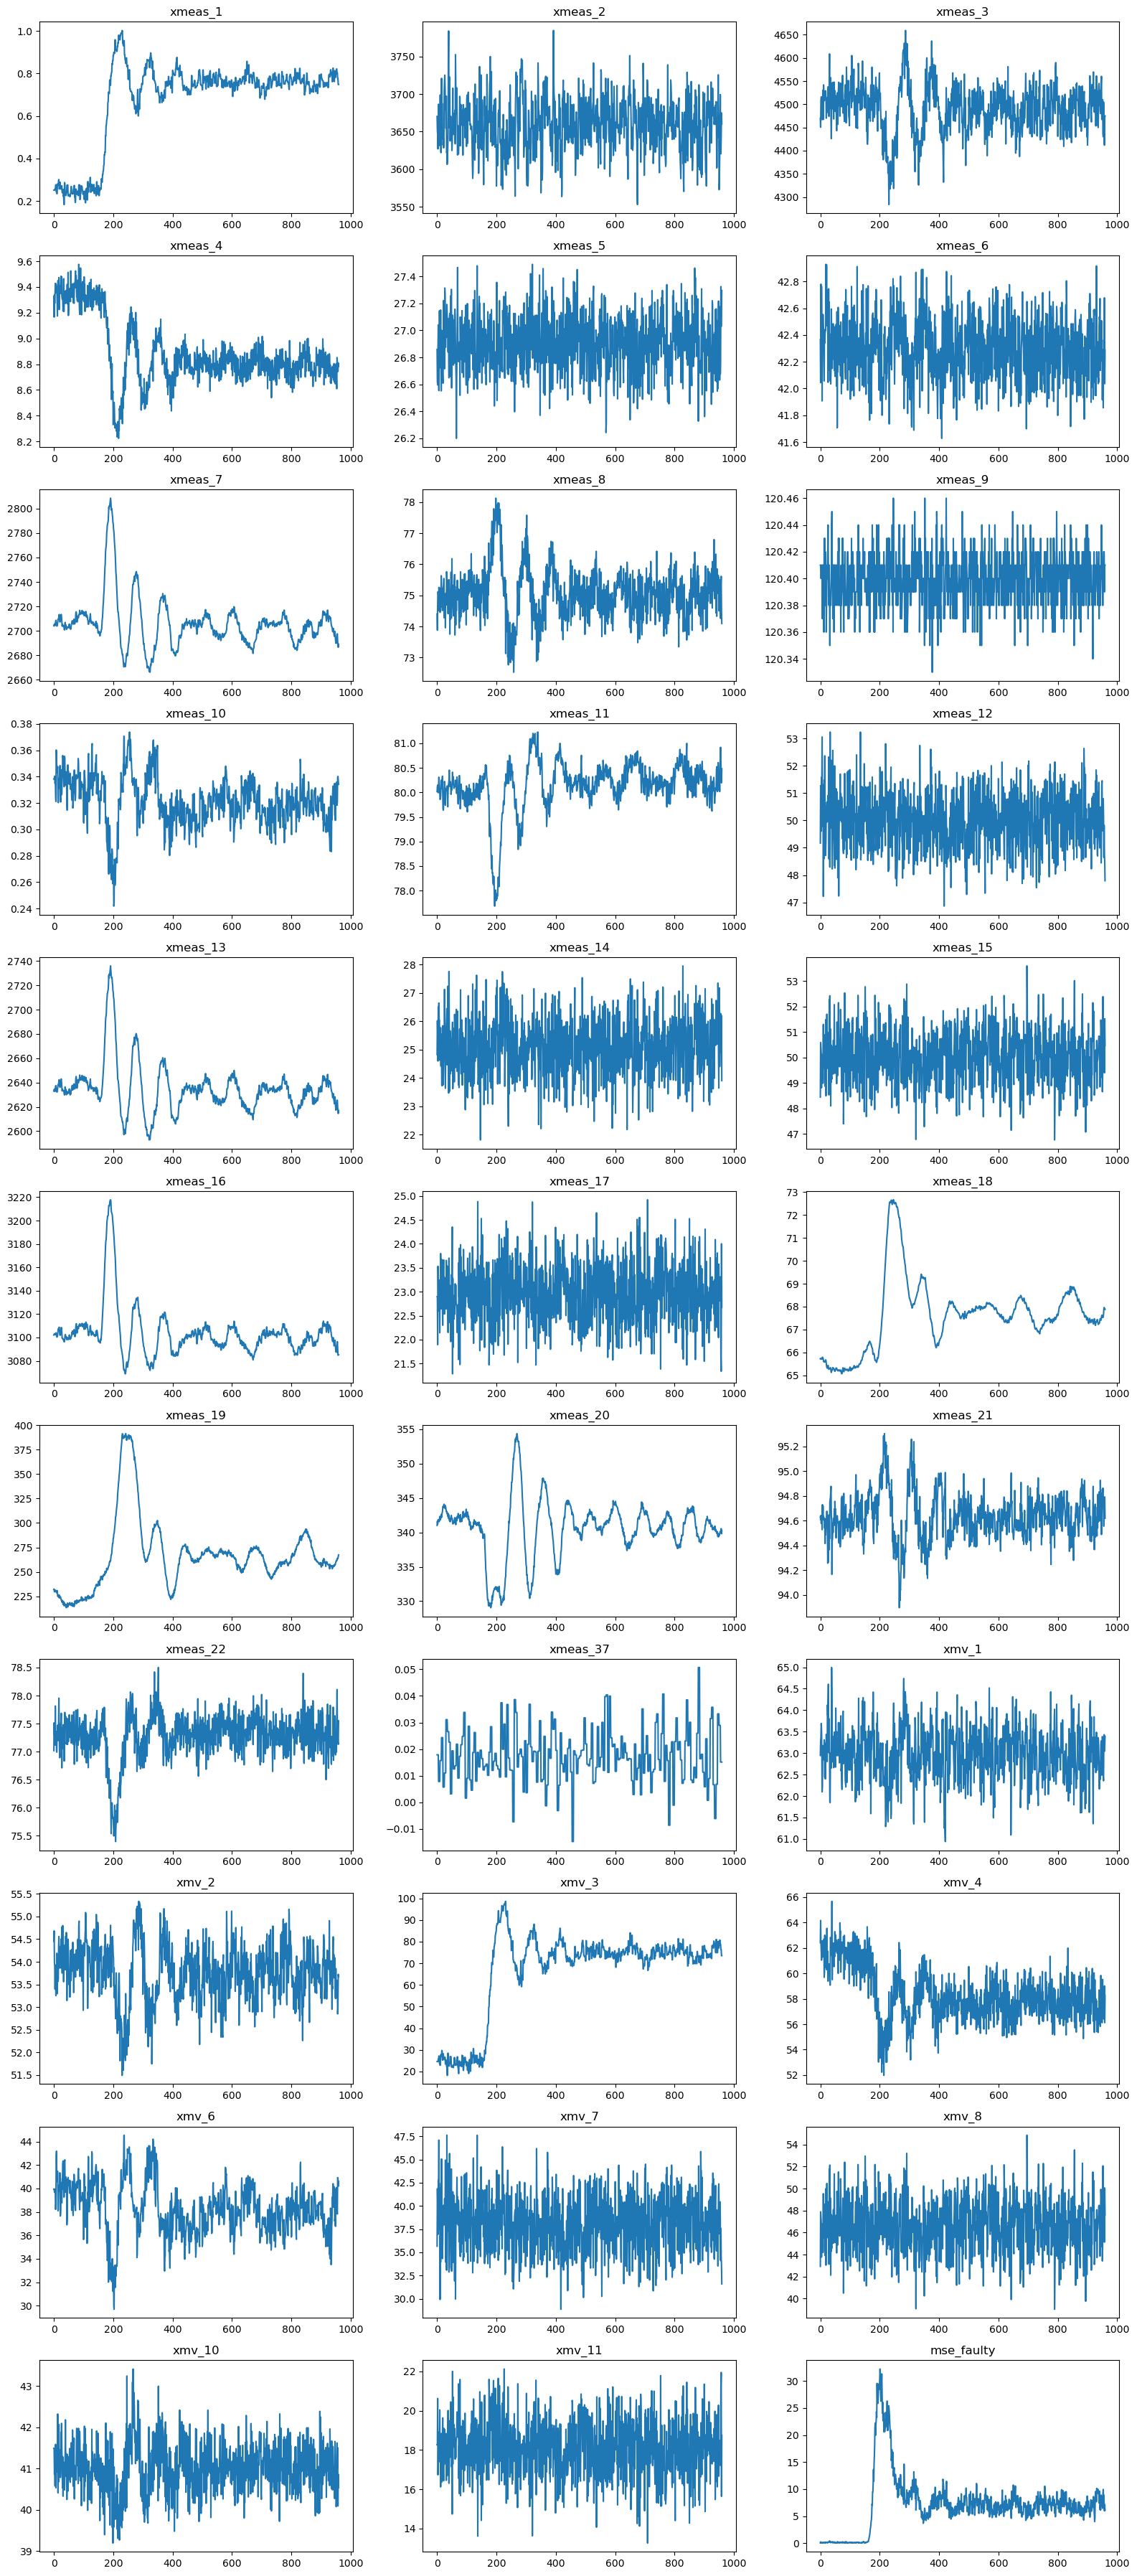

In [10]:
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(16, 36))

for i, column in enumerate(df_filtered_faulty_one_sim_filtered.columns):
    ax = axes[i // 3, i % 3]
    ax.plot(df_filtered_faulty_one_sim_filtered.index, df_filtered_faulty_one_sim_filtered[column])
    ax.set_title(column)

plt.tight_layout()
plt.show()

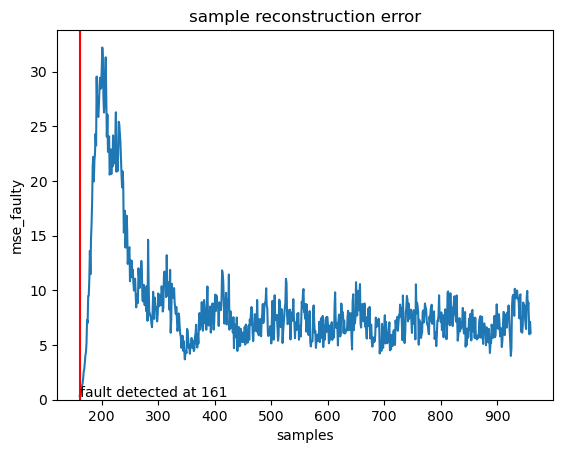

In [11]:
df_to_draw =df_filtered_faulty_one_sim_filtered[df_filtered_faulty_one_sim_filtered['mse_faulty']>threshold]
dict_with_groups=df_to_draw.groupby(df_to_draw.index.to_series().diff().ne(1).cumsum()).groups
for key,group in dict_with_groups.items():
    if len(group)>=5:
        faulty_samples= group
df_to_draw = df_to_draw[df_to_draw.index>=faulty_samples[0]]

plt.plot(df_to_draw.index, df_to_draw['mse_faulty'])
plt.axvline(x=faulty_samples[0], color='red')

# Annotate the point with the x value
plt.text(faulty_samples[0],0,  f"fault detected at {faulty_samples[0]}", horizontalalignment='left', verticalalignment='bottom')
# Add title and labels
plt.title("sample reconstruction error")
plt.xlabel("samples")
plt.ylabel("mse_faulty")
plt.ylim(0, None)

# Show the plot
plt.show()

30/30 [==============================] - 0s 415us/step


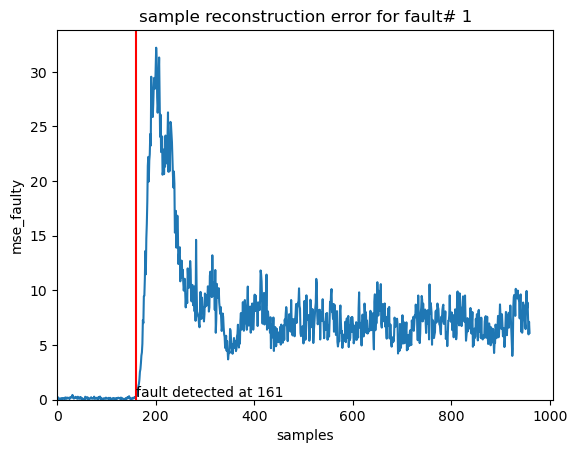

30/30 [==============================] - 0s 304us/step


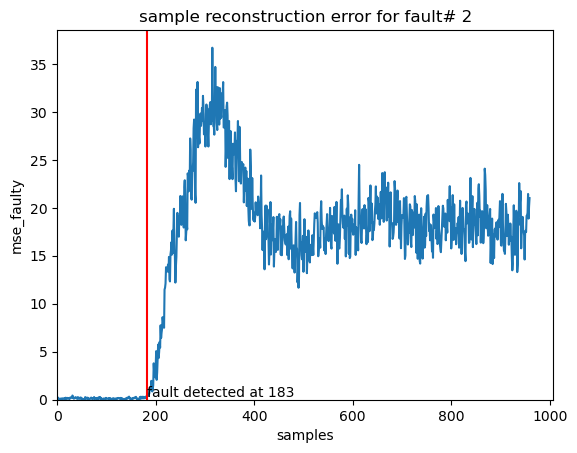

30/30 [==============================] - 0s 256us/step
fault# 3 cannot be detected
30/30 [==============================] - 0s 272us/step


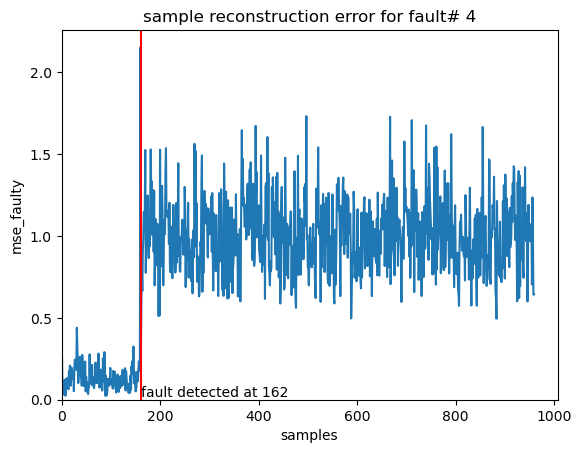

30/30 [==============================] - 0s 348us/step


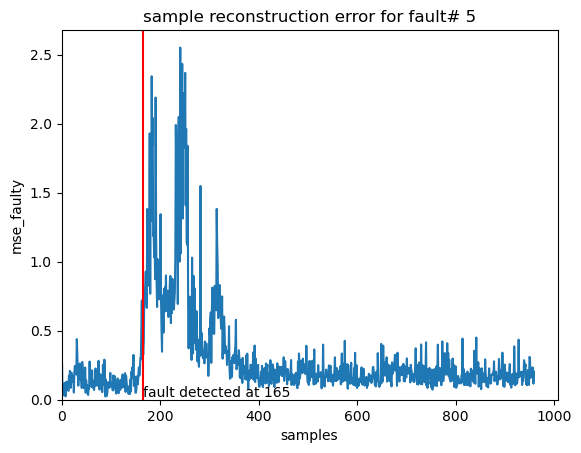

30/30 [==============================] - 0s 363us/step


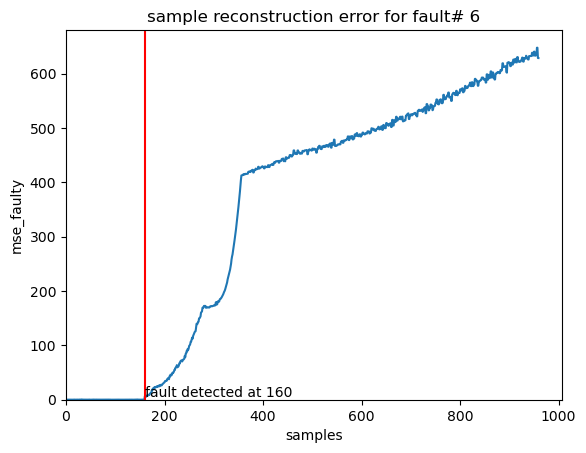

30/30 [==============================] - 0s 261us/step


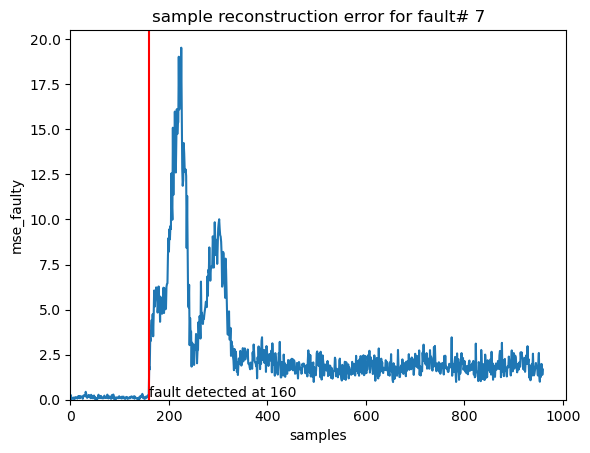

30/30 [==============================] - 0s 252us/step


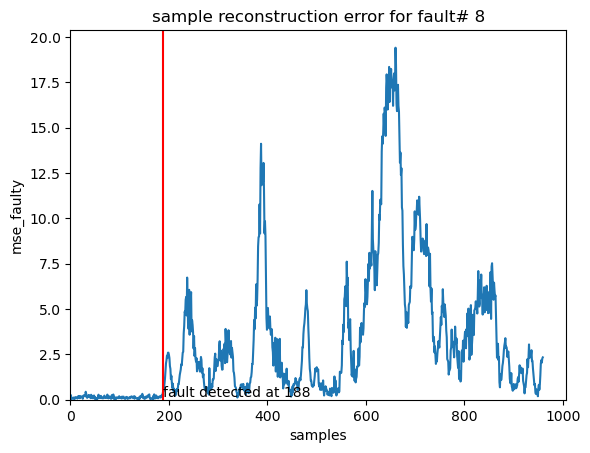

30/30 [==============================] - 0s 276us/step
fault# 9 cannot be detected
30/30 [==============================] - 0s 2ms/step


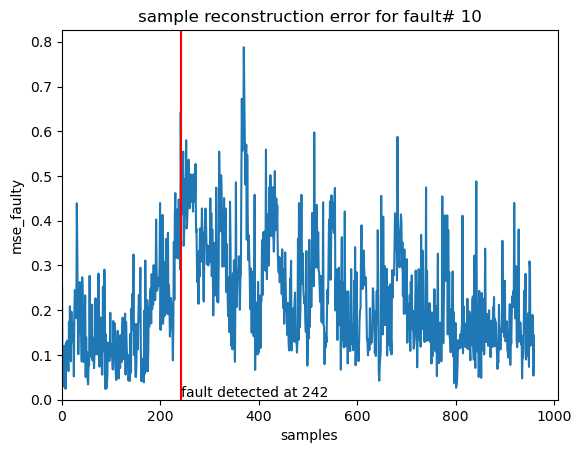

30/30 [==============================] - 0s 261us/step


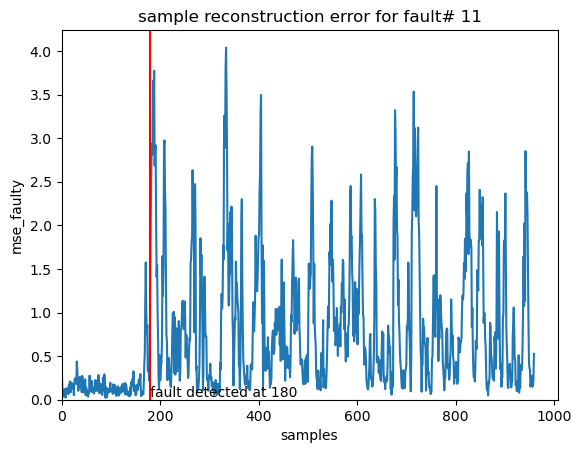

30/30 [==============================] - 0s 257us/step


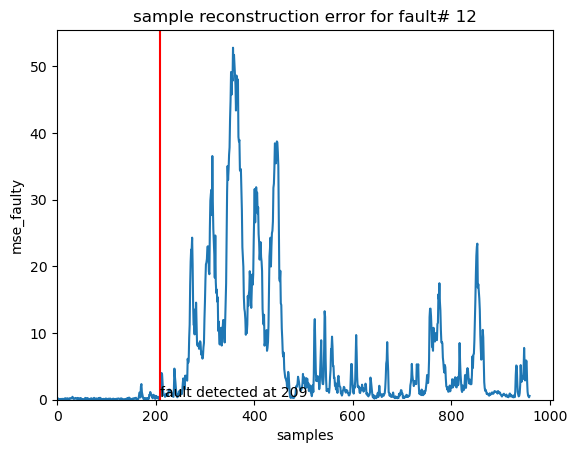

30/30 [==============================] - 0s 253us/step


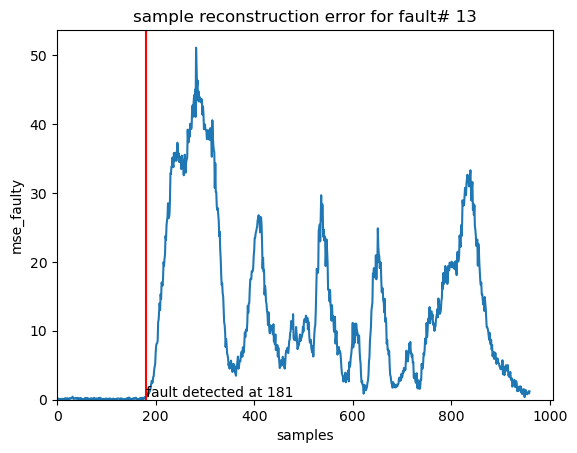

30/30 [==============================] - 0s 255us/step


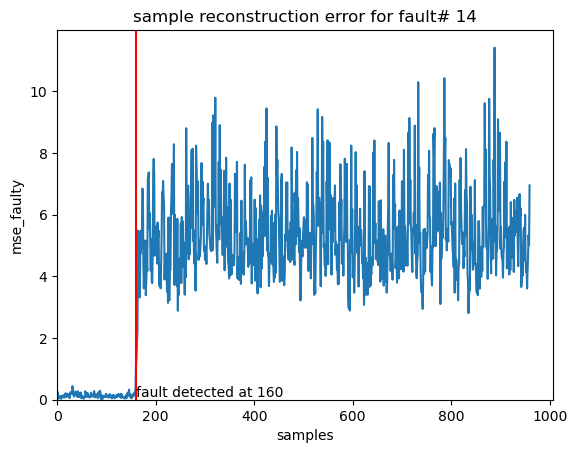

30/30 [==============================] - 0s 255us/step
fault# 15 cannot be detected
30/30 [==============================] - 0s 249us/step
fault# 16 cannot be detected
30/30 [==============================] - 0s 255us/step


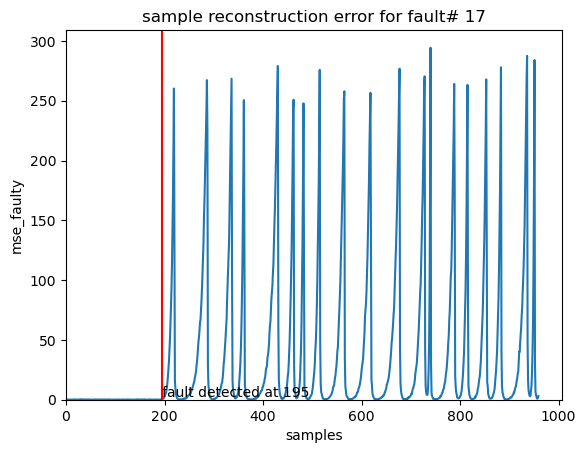

30/30 [==============================] - 0s 260us/step


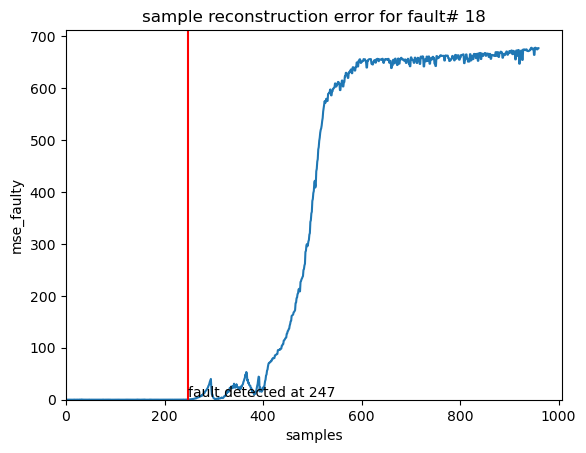

30/30 [==============================] - 0s 258us/step
fault# 19 cannot be detected
30/30 [==============================] - 0s 257us/step


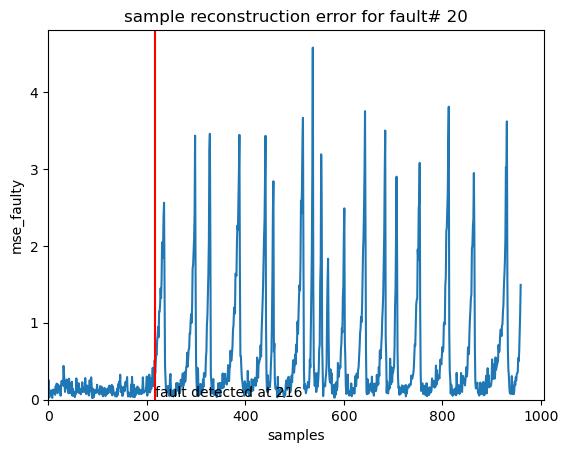

In [12]:
for fault in range(1,21):
    df_faulty_testing_one_sim = df_faulty_testing[(df_faulty_testing['faultNumber']==fault) & (df_faulty_testing['simulationRun']==10)]
    df_filtered_faulty_one_sim_filtered = df_faulty_testing_one_sim.drop(df_faulty_testing_one_sim.columns[[0,1,2,25,26,27,28,29,30,31,32,33,34,35,36,37,38,29,40,41,42,43,48,52]],axis =1)
    df_filtered_faulty_one_sim_filtered = df_filtered_faulty_one_sim_filtered.reset_index(drop=True)
    df_filtered_faulty_one_sim_filtered_scaled = scaler.transform(df_filtered_faulty_one_sim_filtered) 
    #Use the autoencoder to reconstruct the test data
    reconstructed = autoencoder.predict(df_filtered_faulty_one_sim_filtered_scaled)

    # Calculate the mean squared error of the reconstruction
    mse_faulty = mean_squared_error(df_filtered_faulty_one_sim_filtered_scaled.T, reconstructed.T, multioutput='raw_values')

    df_filtered_faulty_one_sim_filtered['reconstruction error'] = mse_faulty
    df_to_draw =df_filtered_faulty_one_sim_filtered[df_filtered_faulty_one_sim_filtered['reconstruction error']>threshold]
    dict_with_groups=df_to_draw.groupby(df_to_draw.index.to_series().diff().ne(1).cumsum()).groups
    faulty_samples=[]
    count_if_first_group=0
    for key,group in dict_with_groups.items():
        if len(group)>=10 and count_if_first_group == 0 :
            count_if_first_group+=1
            faulty_samples= group
            faulty_samples =faulty_samples.to_list()
        
    if not faulty_samples:print(f"fault# {fault} cannot be detected")
        
    else:
    

        plt.plot(df_filtered_faulty_one_sim_filtered.index, df_filtered_faulty_one_sim_filtered['reconstruction error'])
        plt.axvline(x=faulty_samples[0], color='red')

        # Annotate the point with the x value
        plt.text(faulty_samples[0],0,  f"fault detected at {faulty_samples[0]}", horizontalalignment='left', verticalalignment='bottom')
        # Add title and labels
        plt.title(f"sample reconstruction error for fault# {fault}")
        plt.xlabel("samples")
        plt.ylabel("mse_faulty")
        plt.ylim(0, None)
        plt.xlim(0, None)

        # Show the plot
        plt.show()
        

